In [ ]:
!pip install timm torchsummary tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 7.3 MB/s 


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

## Setting up the GPU/CPU
will depend on the selected runtime for colab

In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.device(0)

In [ ]:
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Code to edit the csv with correct image_file paths

In [ ]:
original_image_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training'
cutmix_img_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/cutmix_augmentation'

In [ ]:
# creating a 2d list where the first list contains path of images
# the second list contains a flag denoting whether the image is from original set or bordered
# and the third list contains one-hot encoded label vectors
image_path_list = []

In [ ]:
def img_list(data_path):
  # getting list of all the images
  images = os.listdir(data_path)
  #exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    
    image_path_list.append([data_path + '/' + str(i), list(map(int, i[-13:-4].strip('][').split(', ')))])

In [ ]:
# loading image paths from original dataset
img_list(original_image_path)

In [ ]:
image_path_list[0]

['/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training/444302-21046-34977-[1, 1, 0].png',
 [1, 1, 0]]

In [ ]:
# sorting the image path list from the original list to match the number of tumor-stroma pair to the rest of the dataset and the cut-mix aug data
tum_str = [x for x in image_path_list if '[1, 1, 0]' in x[0]]
print(len(tum_str))
tum_str[0]

5393


['/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training/444302-21046-34977-[1, 1, 0].png',
 [1, 1, 0]]

In [ ]:
image_path_list = [x for x in image_path_list if x not in tum_str]

In [ ]:
print(len(image_path_list))
image_path_list[0]

4698


['/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Dataset/Original/1.training/1.training/449636-25654-12240-[0, 0, 1].png',
 [0, 0, 1]]

In [ ]:
np.random.shuffle(tum_str)

image_path_list.extend(tum_str[:2000])

In [ ]:
len(image_path_list)

6698

In [ ]:
# loading image paths from reflect_101 bordered dataset
img_list(cutmix_img_path)

In [ ]:
len(image_path_list)

12698

In [ ]:
np.random.shuffle(image_path_list)

In [ ]:
train_list, test_list = train_test_split(image_path_list, test_size = 0.2, train_size = 0.8)

In [ ]:
len(train_list)

10158

In [ ]:
len(test_list)

2540

## Creating the dataset class

In [ ]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    labels = self.image_list[idx][1]
    labels = np.array([labels])
    #labels = labels.astype('int').reshape(-1, 3) #.argmax(axis=1)        # reshapes the labels array into (n, 3) array
    labels = labels.astype('float32').reshape(-1)
    #sample = {'image': image, 'labels': labels}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
    
    return image, labels

2540
0 (241, 240, 3) (3,)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


1 (166, 174, 3) (3,)
2 (224, 224, 3) (3,)
3 (224, 224, 3) (3,)


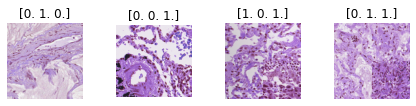

In [ ]:
# check if the dataloader works
check_loader = LUAD(image_list=test_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, labels = check_loader[i]

    print(i, image.shape, labels.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.set_title(labels)
    ax.axis('off')
    #plt.imshow(sample['image'])
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

type(check_loader[1][1])

check_loader[1][1].shape

In [ ]:
# creatin the train dataset
train_dataset = LUAD(train_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),]
                                                     ))

# creating the test dataset
test_dataset = LUAD(test_list,
                    transform = transforms.Compose([transforms.ToTensor(),
                                                    transforms.Resize((224, 224)),
                                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),]
                                                    ))

In [ ]:
batch_size = 128

In [ ]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 1,
                              )

# test dataloader
test_dataloader = DataLoader(test_dataset,
                             batch_size = batch_size,
                             shuffle = True,
                             num_workers = 1,
                             )

In [ ]:
len(train_dataloader)

80

In [ ]:
model_vit_base_patch32_224 = timm.create_model('vit_base_patch32_224', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)
#print(model(torch.randn(1, 3, 224, 224)))

In [ ]:
torchsummary.summary(model_vit_base_patch32_224, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 7, 7]       2,360,064
          Identity-2              [-1, 49, 768]               0
        PatchEmbed-3              [-1, 49, 768]               0
           Dropout-4              [-1, 50, 768]               0
         LayerNorm-5              [-1, 50, 768]           1,536
            Linear-6             [-1, 50, 2304]       1,771,776
           Dropout-7           [-1, 12, 50, 50]               0
            Linear-8              [-1, 50, 768]         590,592
           Dropout-9              [-1, 50, 768]               0
        Attention-10              [-1, 50, 768]               0
         Identity-11              [-1, 50, 768]               0
        LayerNorm-12              [-1, 50, 768]           1,536
           Linear-13             [-1, 50, 3072]       2,362,368
             GELU-14             [-1, 5

### Checking model properties

In [ ]:
next(model_vit_base_patch32_224.parameters()).is_cuda

True

In [ ]:
out = model_vit_base_patch32_224(torch.randn(10, 3, 224, 224).to(device))
out

tensor([[ 0.3176,  0.1367,  0.9850],
        [-0.2594, -0.1025,  0.3803],
        [-0.4695, -0.1653,  0.5947],
        [-0.1699,  0.4397,  0.4780],
        [-1.4433, -0.2663, -0.8707],
        [-0.3385,  0.5171,  0.8992],
        [ 0.7858, -0.0829,  1.6651],
        [-1.0361, -1.6551,  0.2701],
        [-0.5576, -1.3211,  0.8556],
        [ 0.0491,  0.0722,  0.3657]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
#y_pred.argmax(axis=1)

In [ ]:
y_p = nn.functional.sigmoid(out)
y_p

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.5787, 0.5341, 0.7281],
        [0.4355, 0.4744, 0.5939],
        [0.3847, 0.4588, 0.6444],
        [0.4576, 0.6082, 0.6173],
        [0.1910, 0.4338, 0.2951],
        [0.4162, 0.6265, 0.7108],
        [0.6869, 0.4793, 0.8409],
        [0.2619, 0.1604, 0.5671],
        [0.3641, 0.2106, 0.7017],
        [0.5123, 0.5180, 0.5904]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
#y_p = y_p.round().detach().cpu().numpy()
y_p = y_p.round()

In [ ]:
y_p

tensor([[1., 1., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 1.],
        [0., 0., 0.],
        [0., 1., 1.],
        [1., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 1., 1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
y_p.shape

torch.Size([10, 3])

In [ ]:
l = np.array([[0, 0, 1],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 1, 0],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],]).astype('float32')

In [ ]:
l = torch.tensor(l).to(device)

In [ ]:
accuracy_score(l.cpu().detach().numpy(),
               y_p.cpu().detach().numpy())

0.2

In [ ]:
loss = nn.BCEWithLogitsLoss()

In [ ]:
loss(out, l)

tensor(0.6954, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

## Training and validation

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  for batch, (x, y) in enumerate(data_loader):
    
    if batch % 10 == 0: print(f'batch: {batch}')
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)
    
    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model(x)
    y_pred = torch.sigmoid(model_out).round()
    
    # calculate loss
    loss = loss_fn(model_out, y)
    #print(loss) Printed the loss per batch per epoch
    train_loss += loss
    train_acc += eval_fn(y.cpu().detach().numpy(),
                         y_pred.cpu().detach().numpy())

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")

In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      model_out = model(X)
      test_pred = torch.sigmoid(model_out).round()
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(test_pred, y)
      test_acc += eval_fn(y.cpu().detach().numpy(),
                          test_pred.cpu().detach().numpy())
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

In [ ]:
model_save_path = '/content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_vit_base_patch32_224_02.pth'

In [ ]:
epochs = 100

In [ ]:
valid_acc = -np.inf

In [58]:
for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader=train_dataloader,
             model=model_vit_base_patch32_224,
             loss_fn=nn.BCEWithLogitsLoss(),
             opt=Adam(model_vit_base_patch32_224.parameters(), lr=0.0001),
             eval_fn=accuracy_score
             )
  
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model_vit_base_patch32_224,
                                  loss_fn=nn.BCEWithLogitsLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch32_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0
---------
batch: 0
batch: 10
batch: 20
batch: 30
batch: 40
batch: 50
batch: 60
batch: 70
Train loss: 0.63009 | Train accuracy: 0.25626
Test loss: 0.64143 | Test accuracy: 0.19363

accuracy increased from -inf to 0.19363425925925926 saving model to: /content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_vit_base_patch32_224_02.pth
Epoch: 1
---------
batch: 0
batch: 10
batch: 20
batch: 30
batch: 40
batch: 50
batch: 60
batch: 70
Train loss: 0.49655 | Train accuracy: 0.43015
Test loss: 0.57546 | Test accuracy: 0.33818

accuracy increased from 0.19363425925925926 to 0.33817997685185186 saving model to: /content/drive/MyDrive/Newcastle University/Final Project and Dissertation/Models/cutmix_model_vit_base_patch32_224_02.pth
Epoch: 2
---------
batch: 0
batch: 10
batch: 20
batch: 30
batch: 40
batch: 50
batch: 60
batch: 70
Train loss: 0.36852 | Train accuracy: 0.59054
Test loss: 0.54999 | Test accuracy: 0.47720

accuracy increased from 0.33817997

KeyboardInterrupt: ignored